## Getting all node location information 

In [1]:
laser_power_profile_number = 1


In [2]:
import subprocess
import os

def download_with_progress(source_path, target_directory):
    # Define the path for the local download
    local_compressed_file_path = os.path.join(target_directory, os.path.basename(source_path))
    
    # Download the compressed file
    subprocess.run(['rclone', 'copy', source_path, target_directory], check=True)
    print(f"Downloaded {source_path} to {local_compressed_file_path}")

# Example usage
download_with_progress(f'Yi-Ping:/Exp_10_layer/compressed_laser_profile_{laser_power_profile_number}.zarr.zarr.tar.gz', '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing')


Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_1.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_1.zarr.zarr.tar.gz


In [3]:
import tarfile

def decompress_tar_gz(file_path, target_directory):
    # Check if the target directory exists, create if not
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    
    # Open the .tar.gz file
    with tarfile.open(file_path, 'r:gz') as tar:
        # Extract all the contents into the target directory
        tar.extractall(path=target_directory)
        print(f"Decompressed {file_path} into {target_directory}")

# Example usage
file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr.tar.gz"
target_directory = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing' # Change this to your actual target directory
decompress_tar_gz(file_path, target_directory)

Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_1.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


In [8]:
import zarr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d, Rbf

# Assuming nodes_df is already defined and contains 'x', 'y', 'z' columns
# If not, you'll need to read the CSV file as before
filename = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/domain_nodes.csv'
nodes_df = pd.read_csv(filename)

# Add a 'node_number' column starting from 0
nodes_df['node_number'] = np.arange(len(nodes_df))

def zarr_to_df(file_path):
    # Open the Zarr array directly
    zarr_array = zarr.open(file_path, mode='r')
    
    # Ensure the Zarr array is 2D
    if zarr_array.ndim != 2:
        raise ValueError("The Zarr array is not 2D. Additional processing may be required.")
    
    # Convert the Zarr array to a NumPy array then to a DataFrame
    numpy_array = np.array(zarr_array)
    df = pd.DataFrame(numpy_array)
    return df

# Paths to the Zarr arrays for x, y, and z coordinates
file_paths = {
    'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
    'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
    'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
}

# Convert each Zarr array to a DataFrame
dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

# Assuming the DataFrames are aligned and correspond to each other row-wise
# Combine the DataFrames into a single DataFrame with x, y, and z columns
tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
tool_path_df.columns = ['X', 'Y', 'Z']

toolpath_data = tool_path_df.iloc[:6295]

# Desired number of samples for interpolation
desired_samples = 6295

# Interpolating the toolpath data to reduce it to the desired number of samples
df_reduced_laser_location = pd.DataFrame({
    'X': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['X']),
    'Y': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Y']),
    'Z': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Z']),})


# Define the limits for x, y, and z
x_limits = (-20, 20)
y_limits = (-20, 20)
z_limits = (0, 8)

# Function to calculate distance to the nearest edge for each limit
def distance_to_nearest_edge(value, limits):
    return min(value - limits[0], limits[1] - value)

# Calculating the distances and adding them as new columns
df_reduced_laser_location['Dist_to_nearest_X'] = df_reduced_laser_location['X'].apply(distance_to_nearest_edge, args=(x_limits,))
df_reduced_laser_location['Dist_to_nearest_Y'] = df_reduced_laser_location['Y'].apply(distance_to_nearest_edge, args=(y_limits,))
df_reduced_laser_location['Dist_to_nearest_Z'] = 0


from tqdm import tqdm

# Load node locations (assuming this is already loaded as nodes_df with 'x', 'y', 'z', 'node_number')
# Load node temperature data from the Zarr file

solidus_temperature = 400
temp_file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/ff_dt_temperature"
zarr_temp_array = zarr.open(temp_file_path, mode='r')
temperature_data = np.array(zarr_temp_array).squeeze()  # Assuming it's a 2D array (time steps x nodes)
# Pre-define lists to accumulate data
time_steps = []
xs = []
ys = []
zs = []
temperatures = []

for specific_time_step in tqdm(range(len(temperature_data)), desc="Processing Time Steps"):
    specific_temperatures = temperature_data[specific_time_step, :]
    nodes_df['temperature'] = specific_temperatures

    # Filter nodes above solidus temperature and find the max z
    nodes_above_solidus = nodes_df[nodes_df['temperature'] > solidus_temperature]
    max_z = nodes_above_solidus['z'].max()

    # Filter for nodes with max_z
    for _, row in nodes_above_solidus[nodes_above_solidus['z'] == max_z].iterrows():
        time_steps.append(specific_time_step)
        xs.append(row['x'])
        ys.append(row['y'])
        zs.append(row['z'])
        temperatures.append(row['temperature'])

# Load the time index from the Zarr file
file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/timestamp"
zarr_array = zarr.open(file_path, mode='r')
time_index_array = np.array(zarr_array).squeeze()[:6295]  # Assuming it's a 1D array

# Convert lists to DataFrame
all_nodes_with_max_z = pd.DataFrame({
    'time_step': time_steps,
    'x': xs,
    'y': ys,
    'z': zs,
    'temperature': temperatures
})

import zarr
import pandas as pd
import numpy as np

def zarr_to_df(file_path):
    # Open the Zarr array directly
    zarr_array = zarr.open(file_path, mode='r')
    
    # Ensure the Zarr array is 2D
    if zarr_array.ndim != 2:
        raise ValueError("The Zarr array is not 2D. Additional processing may be required.")
    
    # Convert the Zarr array to a NumPy array then to a DataFrame
    numpy_array = np.array(zarr_array)
    df = pd.DataFrame(numpy_array)
    return df

# Paths to the Zarr arrays for x, y, and z coordinates
file_paths = {
    'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
    'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
    'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
}

# Convert each Zarr array to a DataFrame
dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

# Assuming the DataFrames are aligned and correspond to each other row-wise
# Combine the DataFrames into a single DataFrame with x, y, and z columns
tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
tool_path_df.columns = ['x', 'y', 'z']
#tool_path_df = tool_path_df.iloc[1:]
# Now `tool_path_df` contains the combined tool path with x, y, and z coordinates


# Calculating the difference (delta) for each axis to determine direction change
tool_path_df['dx'] = tool_path_df['x'].diff()
tool_path_df['dy'] = tool_path_df['y'].diff()
tool_path_df['dz'] = tool_path_df['z'].diff()

# Since calculating direction at each second requires time data which is not provided,
# We'll just calculate the direction change between each recorded point.
# Note: For accurate per-second analysis, time data would be necessary.

# Simply indicating direction change without normalization for simplicity
direction_changes = tool_path_df[['dx', 'dy', 'dz']].fillna(0)

direction_changes


direction_changes_df = pd.DataFrame(direction_changes)


# Calculate the magnitude of each vector
magnitude = (direction_changes_df['dx']**2 + direction_changes_df['dy']**2 + direction_changes_df['dz']**2)**0.5

# Avoid division by zero by setting zero magnitudes to 1 (effectively making the direction vector [0,0,0] for no movement)
magnitude[magnitude == 0] = 1

# Calculate unit vector components
direction_changes_df['unit_dx'] = direction_changes_df['dx'] / magnitude
direction_changes_df['unit_dy'] = direction_changes_df['dy'] / magnitude
direction_changes_df['unit_dz'] = direction_changes_df['dz'] / magnitude

direction_changes_df[['unit_dx', 'unit_dy', 'unit_dz']]


import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Assuming all_nodes_with_max_z and direction_changes_df are pre-loaded

solidus_temp = 1648.15
liquidus_temp = 1673.15

def fit_temperature_surface(time_step):
    specific_data = all_nodes_with_max_z[all_nodes_with_max_z['time_step'] == time_step]
    if specific_data.empty:
        print(f"No data available for time step {time_step}.")
        return np.nan, np.nan, np.nan
    laser_center = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
    bounding_box = {'xmin': laser_center['x'] - 3, 'xmax': laser_center['x'] + 3,
                    'ymin': laser_center['y'] - 3, 'ymax': laser_center['y'] + 3}
    bounded_data = specific_data[
        (specific_data['x'] >= bounding_box['xmin']) & (specific_data['x'] <= bounding_box['xmax']) &
        (specific_data['y'] >= bounding_box['ymin']) & (specific_data['y'] <= bounding_box['ymax']) &
        (specific_data['temperature'] <= 20000)
    ]
    if bounded_data.shape[0] < 5:
        print(f"Not enough data points for interpolation at time step {time_step}.")
        return [np.nan], np.nan, np.nan, np.nan
    # Prepare points and values for griddata interpolation
    points = bounded_data[['x', 'y']].values
    values = bounded_data['temperature'].values

    return points, values, bounding_box, specific_data

def calculate_melt_pool_temperature(points, values, center_x, center_y, radius=0.45):
    # theta = np.linspace(0, 2 * np.pi, 100)
    # x = center_x + radius * np.cos(theta)
    # y = center_y + radius * np.sin(theta)
    # # Use griddata for interpolation over a circle around the laser center
    # z = griddata(points, values, (x, y), method='linear')
    # return np.nanmean(z)  # Use nanmean to safely handle NaNs

    RBF_surf = Rbf(points[:,0],points[:,1],values, function='linear')
    x_range = np.linspace(center_x-radius,center_x+radius,30)
    y_range = np.linspace(center_y-radius,center_y+radius,30)
    X,Y = np.meshgrid(x_range,y_range)
    Z = RBF_surf(X,Y)
    Xr = X.ravel()
    Yr = Y.ravel()
    in_circle = np.sqrt((Xr-center_x)**2+(Yr-center_y)**2)
    mask = np.where(in_circle<=(radius))
    Zr = Z.ravel()
    Z_in_circle = Zr[mask]
    return np.mean(Z_in_circle)
    

def collect_melt_pool_temperatures():
    temperatures = []
    time_steps = np.sort(all_nodes_with_max_z['time_step'].unique())
    for time_step in tqdm(time_steps):  
        points, values, bounding_box, specific_data = fit_temperature_surface(time_step)
        # Check if points is None or empty
        if len(points) < 5:
        # if points is None or len(points) == 0:
            print(f"No data available for time step {time_step}.")
            temperatures.append(np.nan)  # Append NaN if interpolation data isn't available
            continue
        else:
            tool_position = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
            melt_pool_temp = calculate_melt_pool_temperature(points, values, tool_position['x'], tool_position['y'])
            temperatures.append(melt_pool_temp)
    return np.array(temperatures)

# Collecting melt pool temperatures for all time steps
melt_pool_temperatures = collect_melt_pool_temperatures()
print("Melt Pool Temperatures for All Time Steps:", melt_pool_temperatures)

# Read the data from the file 'toolpath.crs'
file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/toolpath.crs'
df_toolpath_crs = pd.read_csv(file_path, sep='\t', header=None, names=['Time', 'X', 'Y', 'Z', 'Laser State'])

# Interpolating and extrapolating functions for time and scanning speed
def interpolate_extrapolate_time_steps(df_toolpath_crs, new_time_steps):
    valid_points = df_toolpath_crs[df_toolpath_crs['Laser State'] == 1]
    
    # Interpolation functions for X, Y, Z coordinates
    interp_func_x = interp1d(valid_points['Time'], valid_points['X'], fill_value="extrapolate")
    interp_func_y = interp1d(valid_points['Time'], valid_points['Y'], fill_value="extrapolate")
    interp_func_z = interp1d(valid_points['Time'], valid_points['Z'], fill_value="extrapolate")
    
    # Interpolated coordinates for new time steps
    interpolated_x = interp_func_x(new_time_steps)
    interpolated_y = interp_func_y(new_time_steps)
    interpolated_z = interp_func_z(new_time_steps)
    
    return pd.DataFrame({
        'Time': new_time_steps,
        'X': interpolated_x,
        'Y': interpolated_y,
        'Z': interpolated_z
    })

# Define the file path to the Zarr array that contains the laser power data
file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_laser_power"

# Open the Zarr array directly (ensure this is the correct path to the array)
zarr_array = zarr.open(file_path, mode='r')

# Initialize a DataFrame from the Zarr array if it is 2D
if zarr_array.ndim == 2:
    # Convert the Zarr array to a NumPy array
    numpy_array = np.array(zarr_array)
    
    # Convert the NumPy array to a DataFrame and rename columns for clarity
    laser_power_df = pd.DataFrame(numpy_array)
else:
    print("The Zarr array is not 2D. Additional processing may be required.")

laser_power_df = laser_power_df[1:6296]*2.5

# Calculate scanning speed for interpolated/extrapolated time steps
def calculate_scanning_speeds(df_interpolated):
    scanning_speeds = []

    for i in range(1, len(df_interpolated)):
        time1 = df_interpolated.loc[i-1, 'Time']
        time2 = df_interpolated.loc[i, 'Time']
        x1, y1, z1 = df_interpolated.loc[i-1, ['X', 'Y', 'Z']]
        x2, y2, z2 = df_interpolated.loc[i, ['X', 'Y', 'Z']]
        
        # Calculate Euclidean distance
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        
        # Calculate time difference
        time_diff = time2 - time1
        
        # Calculate scanning speed
        if time_diff > 0:
            scanning_speed = distance / time_diff
            scanning_speeds.append({
                'time_step': time2,
                'scanning_speed': scanning_speed
            })

    return pd.DataFrame(scanning_speeds)

# Define new time steps for interpolation/extrapolation
new_time_steps = np.linspace(0, 225, 6296)

# Interpolate and extrapolate the data for the new time steps
df_interpolated = interpolate_extrapolate_time_steps(df_toolpath_crs, new_time_steps)

# Calculate scanning speeds for the interpolated/extrapolated time steps
scanning_speeds_df = calculate_scanning_speeds(df_interpolated)['scanning_speed']


100%|██████████| 6295/6295 [00:48<00:00, 130.62it/s]


Melt Pool Temperatures for All Time Steps: [ 436.10141765  455.97502676 1001.27773009 ...  531.66293445  530.28179624
  528.90999031]


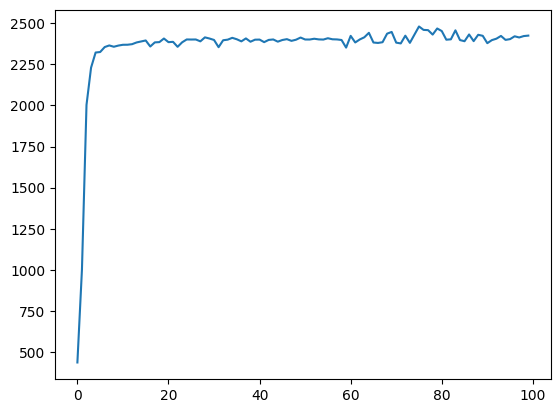

In [13]:
plt.plot(melt_pool_temperatures[:200][::2])

In [ ]:
time_index_df = pd.DataFrame({'time_index': time_index_array})
melt_pool_temperatures_df = pd.DataFrame({'melt_pool_temperature': melt_pool_temperatures[:-1]})
scanning_speeds_df = pd.DataFrame({'scanning_speed': scanning_speeds_df.to_numpy()})
X_df = pd.DataFrame({'X': df_reduced_laser_location['X'].to_numpy()})
Y_df = pd.DataFrame({'Y': df_reduced_laser_location['Y'].to_numpy()})
Z_df = pd.DataFrame({'Z': df_reduced_laser_location['Z'].to_numpy()})
Dist_to_nearest_X_df = pd.DataFrame({'Dist_to_nearest_X': df_reduced_laser_location['Dist_to_nearest_X'].to_numpy()})
Dist_to_nearest_Y_df = pd.DataFrame({'Dist_to_nearest_Y': df_reduced_laser_location['Dist_to_nearest_Y'].to_numpy()})
Dist_to_nearest_Z_df = pd.DataFrame({'Dist_to_nearest_Z': df_reduced_laser_location['Dist_to_nearest_Z'].to_numpy()})
laser_power_number_df = pd.DataFrame({'laser_power_number': df_reduced_laser_location['Dist_to_nearest_Z'].to_numpy()})
laser_power_number_df['laser_power_number']=laser_power_profile_number
laser_power_df.columns = ["Laser_power"]
laser_power_df.reset_index(drop=True, inplace=True)

In [ ]:
# Merging all DataFrames into one
merged_df = pd.concat([
    time_index_df, 
    melt_pool_temperatures_df, 
    scanning_speeds_df, 
    X_df, 
    Y_df, 
    Z_df, 
    Dist_to_nearest_X_df, 
    Dist_to_nearest_Y_df, 
    Dist_to_nearest_Z_df, 
    laser_power_df,
    laser_power_number_df
], axis=1)

In [ ]:
import shutil

os.remove(f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr.tar.gz")
shutil.rmtree(f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr")


In [4]:
csv_file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/single_laser_profile.csv'
merged_df.to_csv(csv_file_path, index=False)

NameError: name 'merged_df' is not defined

# Complete For Loop

In [1]:

import subprocess
import os
import tarfile
import zarr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, Rbf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import copy

### Functions

In [2]:
def download_with_progress(source_path, target_directory):
    # Define the path for the local download
    local_compressed_file_path = os.path.join(target_directory, os.path.basename(source_path))
    
    # Download the compressed file
    subprocess.run(['rclone', 'copy', source_path, target_directory], check=True)
    print(f"Downloaded {source_path} to {local_compressed_file_path}")
    
    

def decompress_tar_gz(file_path, target_directory):
    # Check if the target directory exists, create if not
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    
    # Open the .tar.gz file
    with tarfile.open(file_path, 'r:gz') as tar:
        # Extract all the contents into the target directory
        tar.extractall(path=target_directory)
        print(f"Decompressed {file_path} into {target_directory}")
        
def zarr_to_df(file_path):
    # Open the Zarr array directly
    zarr_array = zarr.open(file_path, mode='r')
    
    # Ensure the Zarr array is 2D
    if zarr_array.ndim != 2:
        raise ValueError("The Zarr array is not 2D. Additional processing may be required.")
    
    # Convert the Zarr array to a NumPy array then to a DataFrame
    numpy_array = np.array(zarr_array)
    df = pd.DataFrame(numpy_array)
    return df

def fit_temperature_surface(time_step):
    specific_data = all_nodes_with_max_z[all_nodes_with_max_z['time_step'] == time_step]
    if specific_data.empty:
        print(f"No data available for time step {time_step}.")
        return np.nan, np.nan, np.nan
    laser_center = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
    bounding_box = {'xmin': laser_center['x'] - 3, 'xmax': laser_center['x'] + 3,
                    'ymin': laser_center['y'] - 3, 'ymax': laser_center['y'] + 3}
    bounded_data = specific_data[
        (specific_data['x'] >= bounding_box['xmin']) & (specific_data['x'] <= bounding_box['xmax']) &
        (specific_data['y'] >= bounding_box['ymin']) & (specific_data['y'] <= bounding_box['ymax']) &
        (specific_data['temperature'] <= 20000)
    ]
    if bounded_data.shape[0] < 5:
        print(f"Not enough data points for interpolation at time step {time_step}.")
        return [np.nan], np.nan, np.nan, np.nan
    # Prepare points and values for griddata interpolation
    points = bounded_data[['x', 'y']].values
    values = bounded_data['temperature'].values

    return points, values, bounding_box, specific_data

def calculate_melt_pool_temperature(points, values, center_x, center_y, radius=0.45):
    # theta = np.linspace(0, 2 * np.pi, 100)
    # x = center_x + radius * np.cos(theta)
    # y = center_y + radius * np.sin(theta)
    # # Use griddata for interpolation over a circle around the laser center
    # z = griddata(points, values, (x, y), method='linear')
    # return np.nanmean(z)  # Use nanmean to safely handle NaNs

    RBF_surf = Rbf(points[:,0],points[:,1],values, function='linear')
    x_range = np.linspace(center_x-radius,center_x+radius,30)
    y_range = np.linspace(center_y-radius,center_y+radius,30)
    X,Y = np.meshgrid(x_range,y_range)
    Z = RBF_surf(X,Y)
    Xr = X.ravel()
    Yr = Y.ravel()
    in_circle = np.sqrt((Xr-center_x)**2+(Yr-center_y)**2)
    mask = np.where(in_circle<=(radius))
    Zr = Z.ravel()
    Z_in_circle = Zr[mask]
    return np.mean(Z_in_circle)

# def collect_melt_pool_temperatures():
#     temperatures = []
#     time_steps = np.sort(all_nodes_with_max_z['time_step'].unique())
#     for time_step in tqdm(time_steps[::2]):  
#         points, values, bounding_box, specific_data = fit_temperature_surface(time_step)
#         # Check if points is None or empty
#         if points is None or len(points) == 0:
#             print(f"No data available for time step {time_step}.")
#             temperatures.append(np.nan)  # Append NaN if interpolation data isn't available
#             continue
#         tool_position = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
#         melt_pool_temp = calculate_melt_pool_temperature(points, values, tool_position['x'], tool_position['y'])
#         temperatures.append(melt_pool_temp)
#         temperatures.append(melt_pool_temp)    
#     return np.array(temperatures)

def collect_melt_pool_temperatures():
    temperatures = []
    time_steps = np.sort(all_nodes_with_max_z['time_step'].unique())
    for time_step in tqdm(time_steps):  
        points, values, bounding_box, specific_data = fit_temperature_surface(time_step)
        # Check if points is None or empty
        if len(points) < 5:
        # if points is None or len(points) == 0:
            print(f"No data available for time step {time_step}.")
            temperatures.append(np.nan)  # Append NaN if interpolation data isn't available
            continue
        else:
            tool_position = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
            melt_pool_temp = calculate_melt_pool_temperature(points, values, tool_position['x'], tool_position['y'])
            temperatures.append(melt_pool_temp)
    return np.array(temperatures)

# Interpolating and extrapolating functions for time and scanning speed
def interpolate_extrapolate_time_steps(df_toolpath_crs, new_time_steps):
    valid_points = df_toolpath_crs[df_toolpath_crs['Laser State'] == 1]
    
    # Interpolation functions for X, Y, Z coordinates
    interp_func_x = interp1d(valid_points['Time'], valid_points['X'], fill_value="extrapolate")
    interp_func_y = interp1d(valid_points['Time'], valid_points['Y'], fill_value="extrapolate")
    interp_func_z = interp1d(valid_points['Time'], valid_points['Z'], fill_value="extrapolate")
    
    # Interpolated coordinates for new time steps
    interpolated_x = interp_func_x(new_time_steps)
    interpolated_y = interp_func_y(new_time_steps)
    interpolated_z = interp_func_z(new_time_steps)
    
    return pd.DataFrame({
        'Time': new_time_steps,
        'X': interpolated_x,
        'Y': interpolated_y,
        'Z': interpolated_z
    })
    
# Calculate scanning speed for interpolated/extrapolated time steps
def calculate_scanning_speeds(df_interpolated):
    scanning_speeds = []

    for i in range(1, len(df_interpolated)):
        time1 = df_interpolated.loc[i-1, 'Time']
        time2 = df_interpolated.loc[i, 'Time']
        x1, y1, z1 = df_interpolated.loc[i-1, ['X', 'Y', 'Z']]
        x2, y2, z2 = df_interpolated.loc[i, ['X', 'Y', 'Z']]
        
        # Calculate Euclidean distance
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        
        # Calculate time difference
        time_diff = time2 - time1
        
        # Calculate scanning speed
        if time_diff > 0:
            scanning_speed = distance / time_diff
            scanning_speeds.append({
                'time_step': time2,
                'scanning_speed': scanning_speed
            })

    return pd.DataFrame(scanning_speeds)



In [3]:
laser_power_profile_number = 1
for laser_number in range(97):

# laser_power_profile_number = 0
# for laser_number in range(1):
    laser_power_profile_number += 1
    if laser_power_profile_number == 80:
        laser_power_profile_number = 81
    
    # download
    download_with_progress(f'Yi-Ping:/Exp_10_layer/compressed_laser_profile_{laser_power_profile_number}.zarr.zarr.tar.gz', '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing')
    # decompress
    file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr.tar.gz"
    target_directory = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing' # Change this to your actual target directory
    decompress_tar_gz(file_path, target_directory)
    
    # Assuming nodes_df is already defined and contains 'x', 'y', 'z' columns
    # If not, you'll need to read the CSV file as before
    filename = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/domain_nodes.csv'
    nodes_df = pd.read_csv(filename)

    # Add a 'node_number' column starting from 0
    nodes_df['node_number'] = np.arange(len(nodes_df))
    
    # Paths to the Zarr arrays for x, y, and z coordinates
    file_paths = {
        'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
        'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
        'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
    }

    # Convert each Zarr array to a DataFrame
    dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

    # Assuming the DataFrames are aligned and correspond to each other row-wise
    # Combine the DataFrames into a single DataFrame with x, y, and z columns
    tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
    tool_path_df.columns = ['X', 'Y', 'Z']

    toolpath_data = tool_path_df.iloc[:6295]

    # Desired number of samples for interpolation
    desired_samples = 6295

    # Interpolating the toolpath data to reduce it to the desired number of samples
    df_reduced_laser_location = pd.DataFrame({
        'X': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['X']),
        'Y': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Y']),
        'Z': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Z']),})


    # Define the limits for x, y, and z
    x_limits = (-20, 20)
    y_limits = (-20, 20)
    z_limits = (0, 8)

    # Function to calculate distance to the nearest edge for each limit
    def distance_to_nearest_edge(value, limits):
        return min(value - limits[0], limits[1] - value)

    # Calculating the distances and adding them as new columns
    df_reduced_laser_location['Dist_to_nearest_X'] = df_reduced_laser_location['X'].apply(distance_to_nearest_edge, args=(x_limits,))
    df_reduced_laser_location['Dist_to_nearest_Y'] = df_reduced_laser_location['Y'].apply(distance_to_nearest_edge, args=(y_limits,))
    df_reduced_laser_location['Dist_to_nearest_Z'] = 0


    from tqdm import tqdm

    # Load node locations (assuming this is already loaded as nodes_df with 'x', 'y', 'z', 'node_number')
    # Load node temperature data from the Zarr file

    solidus_temperature = 400
    temp_file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/ff_dt_temperature"
    zarr_temp_array = zarr.open(temp_file_path, mode='r')
    temperature_data = np.array(zarr_temp_array).squeeze()  # Assuming it's a 2D array (time steps x nodes)
    # Pre-define lists to accumulate data
    time_steps = []
    xs = []
    ys = []
    zs = []
    temperatures = []

    for specific_time_step in tqdm(range(len(temperature_data)), desc="Processing Time Steps"):
        specific_temperatures = temperature_data[specific_time_step, :]
        nodes_df['temperature'] = specific_temperatures

        # Filter nodes above solidus temperature and find the max z
        nodes_above_solidus = nodes_df[nodes_df['temperature'] > solidus_temperature]
        max_z = nodes_above_solidus['z'].max()

        # Filter for nodes with max_z
        for _, row in nodes_above_solidus[nodes_above_solidus['z'] == max_z].iterrows():
            time_steps.append(specific_time_step)
            xs.append(row['x'])
            ys.append(row['y'])
            zs.append(row['z'])
            temperatures.append(row['temperature'])

    # Load the time index from the Zarr file
    file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/timestamp"
    zarr_array = zarr.open(file_path, mode='r')
    time_index_array = np.array(zarr_array).squeeze()[:6295]  # Assuming it's a 1D array

    # Convert lists to DataFrame
    all_nodes_with_max_z = pd.DataFrame({
        'time_step': time_steps,
        'x': xs,
        'y': ys,
        'z': zs,
        'temperature': temperatures
    })


        # Paths to the Zarr arrays for x, y, and z coordinates
    file_paths = {
        'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
        'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
        'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
    }

    # Convert each Zarr array to a DataFrame
    dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

    # Assuming the DataFrames are aligned and correspond to each other row-wise
    # Combine the DataFrames into a single DataFrame with x, y, and z columns
    tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
    tool_path_df.columns = ['x', 'y', 'z']
    #tool_path_df = tool_path_df.iloc[1:]
    # Now `tool_path_df` contains the combined tool path with x, y, and z coordinates


    # Calculating the difference (delta) for each axis to determine direction change
    tool_path_df['dx'] = tool_path_df['x'].diff()
    tool_path_df['dy'] = tool_path_df['y'].diff()
    tool_path_df['dz'] = tool_path_df['z'].diff()

    # Since calculating direction at each second requires time data which is not provided,
    # We'll just calculate the direction change between each recorded point.
    # Note: For accurate per-second analysis, time data would be necessary.

    # Simply indicating direction change without normalization for simplicity
    direction_changes = tool_path_df[['dx', 'dy', 'dz']].fillna(0)

    direction_changes


    direction_changes_df = pd.DataFrame(direction_changes)

    # Calculate the magnitude of each vector
    magnitude = (direction_changes_df['dx']**2 + direction_changes_df['dy']**2 + direction_changes_df['dz']**2)**0.5

    # Avoid division by zero by setting zero magnitudes to 1 (effectively making the direction vector [0,0,0] for no movement)
    magnitude[magnitude == 0] = 1

    # Calculate unit vector components
    direction_changes_df['unit_dx'] = direction_changes_df['dx'] / magnitude
    direction_changes_df['unit_dy'] = direction_changes_df['dy'] / magnitude
    direction_changes_df['unit_dz'] = direction_changes_df['dz'] / magnitude

    direction_changes_df[['unit_dx', 'unit_dy', 'unit_dz']]
    
    # Assuming all_nodes_with_max_z and direction_changes_df are pre-loaded

    solidus_temp = 1648.15
    liquidus_temp = 1673.15
    
    # Collecting melt pool temperatures for all time steps
    melt_pool_temperatures = collect_melt_pool_temperatures()
    print("Melt Pool Temperatures for All Time Steps:", melt_pool_temperatures)

    # Read the data from the file 'toolpath.crs'
    file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/toolpath.crs'
    df_toolpath_crs = pd.read_csv(file_path, sep='\t', header=None, names=['Time', 'X', 'Y', 'Z', 'Laser State'])


    # Define the file path to the Zarr array that contains the laser power data
    file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_laser_power"

    # Open the Zarr array directly (ensure this is the correct path to the array)
    zarr_array = zarr.open(file_path, mode='r')

    # Initialize a DataFrame from the Zarr array if it is 2D
    if zarr_array.ndim == 2:
        # Convert the Zarr array to a NumPy array
        numpy_array = np.array(zarr_array)
        
        # Convert the NumPy array to a DataFrame and rename columns for clarity
        laser_power_df = pd.DataFrame(numpy_array)
    else:
        print("The Zarr array is not 2D. Additional processing may be required.")

    laser_power_df = laser_power_df[1:6296]*2.5
    
    # Define new time steps for interpolation/extrapolation
    new_time_steps = np.linspace(0, 225, 6296)

    # Interpolate and extrapolate the data for the new time steps
    df_interpolated = interpolate_extrapolate_time_steps(df_toolpath_crs, new_time_steps)

    # Calculate scanning speeds for the interpolated/extrapolated time steps
    scanning_speeds_df = calculate_scanning_speeds(df_interpolated)['scanning_speed']
    
    
    time_index_df = pd.DataFrame({'time_index': time_index_array})
    melt_pool_temperatures_df = pd.DataFrame({'melt_pool_temperature': melt_pool_temperatures[:-1]})
    scanning_speeds_df = pd.DataFrame({'scanning_speed': scanning_speeds_df.to_numpy()})
    X_df = pd.DataFrame({'X': df_reduced_laser_location['X'].to_numpy()})
    Y_df = pd.DataFrame({'Y': df_reduced_laser_location['Y'].to_numpy()})
    Z_df = pd.DataFrame({'Z': df_reduced_laser_location['Z'].to_numpy()})
    Dist_to_nearest_X_df = pd.DataFrame({'Dist_to_nearest_X': df_reduced_laser_location['Dist_to_nearest_X'].to_numpy()})
    Dist_to_nearest_Y_df = pd.DataFrame({'Dist_to_nearest_Y': df_reduced_laser_location['Dist_to_nearest_Y'].to_numpy()})
    Dist_to_nearest_Z_df = pd.DataFrame({'Dist_to_nearest_Z': df_reduced_laser_location['Dist_to_nearest_Z'].to_numpy()})
    laser_power_number_df = pd.DataFrame({'laser_power_number': df_reduced_laser_location['Dist_to_nearest_Z'].to_numpy()})
    laser_power_number_df['laser_power_number']=laser_power_profile_number
    laser_power_df.columns = ["Laser_power"]
    laser_power_df.reset_index(drop=True, inplace=True)
    
    # Merging all DataFrames into one
    
    try:
        merged_df_new = pd.concat([
            time_index_df, 
            melt_pool_temperatures_df, 
            scanning_speeds_df, 
            X_df, 
            Y_df, 
            Z_df, 
            Dist_to_nearest_X_df, 
            Dist_to_nearest_Y_df, 
            Dist_to_nearest_Z_df, 
            laser_power_df,
            laser_power_number_df
        ], axis=1)
    
        merged_df = pd.concat([merged_df,merged_df_new],axis=0)

    except:
        merged_df = pd.concat([
            time_index_df, 
            melt_pool_temperatures_df, 
            scanning_speeds_df, 
            X_df, 
            Y_df, 
            Z_df, 
            Dist_to_nearest_X_df, 
            Dist_to_nearest_Y_df, 
            Dist_to_nearest_Z_df, 
            laser_power_df,
            laser_power_number_df
        ], axis=1)
    
    
    import shutil

    os.remove(f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr.tar.gz")
    shutil.rmtree(f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr")



csv_file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/merged_data_13_.csv'

Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_2.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_2.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_2.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:56<00:00, 110.45it/s]


Melt Pool Temperatures for All Time Steps: [ 436.60750221  456.64453316 1004.17931731 ...  537.9644966   536.54353299
  535.13218206]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_3.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_3.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_3.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:56<00:00, 112.32it/s]


Melt Pool Temperatures for All Time Steps: [ 430.91811837  505.48702307 1155.26239382 ...  544.34904525  542.88636407
  541.43361039]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_4.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_4.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_4.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:06<00:00, 94.28it/s] 


Melt Pool Temperatures for All Time Steps: [ 435.37441352  513.06361374 1183.37903249 ...  557.52818236  555.98180878
  554.44596805]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_5.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_5.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_5.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 119.01it/s]


Melt Pool Temperatures for All Time Steps: [ 428.44375587  501.77161417 1139.67837554 ...  545.599373    544.12944566
  542.66949009]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_6.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_6.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_6.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:49<00:00, 128.17it/s]


Melt Pool Temperatures for All Time Steps: [ 444.32320977  527.0536312  1239.86047109 ...  550.16011862  548.66063446
  547.17134156]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_7.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_7.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_7.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:47<00:00, 133.08it/s]


Melt Pool Temperatures for All Time Steps: [ 442.87278158  470.22351925 1039.87767296 ...  525.72561224  524.38236315
  523.04817243]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_8.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_8.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_8.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:50<00:00, 124.73it/s]


Melt Pool Temperatures for All Time Steps: [ 430.52452926  504.89532442 1152.77157448 ...  554.16205036  552.63719689
  551.12271845]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_9.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_9.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_9.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:47<00:00, 133.59it/s]


Melt Pool Temperatures for All Time Steps: [ 432.18014723  508.25630657 1163.21009412 ...  543.16604566  541.71097541
  540.26577792]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_10.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_10.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_10.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 120.76it/s]


Melt Pool Temperatures for All Time Steps: [ 444.0533046   526.65347429 1238.25349822 ...  554.47346708  552.94713425
  551.43118328]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_11.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_11.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_11.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 122.02it/s]


Melt Pool Temperatures for All Time Steps: [ 449.78052251  479.49205322 1079.35029081 ...  526.66853051  525.31991977
  523.98039917]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_12.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_12.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_12.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


  0%|          | 21/6295 [00:00<00:31, 199.60it/s]

Not enough data points for interpolation at time step 1.
No data available for time step 1.


100%|██████████| 6295/6295 [00:59<00:00, 105.54it/s]


Melt Pool Temperatures for All Time Steps: [         nan 452.52261608 986.44243059 ... 532.71317448 531.32578429
 529.94776679]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_13.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_13.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_13.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 122.61it/s]


Melt Pool Temperatures for All Time Steps: [ 448.0206094   477.12922388 1069.26151742 ...  537.33806443  535.92042678
  534.51238692]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_14.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_14.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_14.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 121.36it/s]


Melt Pool Temperatures for All Time Steps: [ 459.00974103  499.4965964  1132.18133203 ...  545.24333299  543.77559128
  542.31780541]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_15.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_15.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_15.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:54<00:00, 116.51it/s]


Melt Pool Temperatures for All Time Steps: [ 445.59666314  473.88096853 1055.47139995 ...  528.5741328   527.21238821
  525.85983848]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_16.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_16.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_16.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:04<00:00, 97.34it/s] 


Melt Pool Temperatures for All Time Steps: [ 432.12556956  508.17476407 1162.8745423  ...  547.50245295  546.02083636
  544.54927183]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_17.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_17.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_17.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:49<00:00, 127.48it/s]


Melt Pool Temperatures for All Time Steps: [ 433.33054437  509.98715929 1170.4644036  ...  545.36622449  543.89789453
  542.43952435]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_18.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_18.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_18.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 122.67it/s]


Melt Pool Temperatures for All Time Steps: [ 451.62413836  481.9635956  1089.86938518 ...  527.00992968  525.6593635
  524.31789773]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_19.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_19.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_19.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:46<00:00, 136.85it/s]


Melt Pool Temperatures for All Time Steps: [ 449.44327527  479.03899341 1077.41238304 ...  531.73664998  530.3550215
  528.9827282 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_20.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_20.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_20.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:57<00:00, 109.62it/s]


Melt Pool Temperatures for All Time Steps: [ 433.9048428   510.85171419 1174.09400809 ...  546.08783383  544.61520268
  543.152559  ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_21.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_21.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_21.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


  0%|          | 14/6295 [00:00<00:46, 134.59it/s]

Not enough data points for interpolation at time step 1.
No data available for time step 1.


100%|██████████| 6295/6295 [00:51<00:00, 122.98it/s]


Melt Pool Temperatures for All Time Steps: [         nan 453.03604041 988.62452452 ... 532.0448584  530.66168516
 529.28785396]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_22.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_22.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_22.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:50<00:00, 124.92it/s]


Melt Pool Temperatures for All Time Steps: [ 444.97994048  528.0480194  1244.08073011 ...  555.33199321  553.80010533
  552.27863927]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_23.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_23.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_23.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:07<00:00, 93.16it/s] 


Melt Pool Temperatures for All Time Steps: [ 456.71467423  495.37266727 1119.0427656  ...  545.20442929  543.73756345
  542.28064043]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_24.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_24.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_24.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:12<00:00, 86.98it/s] 


Melt Pool Temperatures for All Time Steps: [ 450.71625656  480.74706144 1084.69711924 ...  538.51199998  537.08736534
  535.67237307]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_25.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_25.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_25.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:18<00:00, 80.53it/s] 


Melt Pool Temperatures for All Time Steps: [ 442.00424312  523.56158408 1225.2534189  ...  554.2461641   552.7201673
  551.20456075]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_26.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_26.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_26.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 120.25it/s]


Melt Pool Temperatures for All Time Steps: [ 448.62932415  477.94401665 1072.71318942 ...  530.85250567  529.47710753
  528.11099611]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_27.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_27.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_27.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:56<00:00, 110.82it/s]


Melt Pool Temperatures for All Time Steps: [ 446.61716513  530.51802442 1254.46573363 ...  553.54530704  552.02473703
  550.51450823]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_28.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_28.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_28.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:18<00:00, 79.77it/s] 


Melt Pool Temperatures for All Time Steps: [ 440.89713816  521.89057271 1218.22655474 ...  546.48978272  545.01402519
  543.54828412]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_29.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_29.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_29.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 120.04it/s]


Melt Pool Temperatures for All Time Steps: [ 449.43597358  479.02954666 1077.37591352 ...  538.28889481  536.86548177
  535.45170553]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_30.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_30.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_30.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:55<00:00, 114.45it/s]


Melt Pool Temperatures for All Time Steps: [ 455.29246055  493.43335835 1110.88228082 ...  541.84119606  540.39472277
  538.95805926]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_31.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_31.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_31.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:57<00:00, 109.98it/s]


Melt Pool Temperatures for All Time Steps: [ 440.74091194  462.10438515 1027.76671827 ...  532.4927427   531.10690548
  529.73042815]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_32.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_32.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_32.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:58<00:00, 107.04it/s]


Melt Pool Temperatures for All Time Steps: [ 445.5281605   473.78458981 1055.01265843 ...  538.8437993   537.41686503
  535.99959091]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_33.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_33.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_33.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:47<00:00, 131.55it/s]


Melt Pool Temperatures for All Time Steps: [ 437.49644927  457.81921108 1009.25620592 ...  528.68160257  527.31934809
  525.96629211]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_34.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_34.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_34.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 119.66it/s]


Melt Pool Temperatures for All Time Steps: [ 429.52268286  503.39237848 1146.48070972 ...  548.32336335  546.83579825
  545.35833672]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_35.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_35.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_35.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:48<00:00, 130.30it/s]


Melt Pool Temperatures for All Time Steps: [ 445.83755841  529.34355997 1249.54798663 ...  556.73728706  555.19646488
  553.66612916]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_36.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_36.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_36.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:53<00:00, 116.98it/s]


Melt Pool Temperatures for All Time Steps: [ 450.38445011  480.30322323 1082.81888427 ...  545.38622073  543.9179576
  542.4596514 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_37.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_37.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_37.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 122.97it/s]


Melt Pool Temperatures for All Time Steps: [ 447.90270967  532.45536423 1262.56407595 ...  558.02744544  556.47860782
  554.94031208]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_38.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_38.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_38.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


  0%|          | 11/6295 [00:00<00:58, 106.96it/s]

Not enough data points for interpolation at time step 1.
No data available for time step 1.


100%|██████████| 6295/6295 [00:49<00:00, 127.35it/s]


Melt Pool Temperatures for All Time Steps: [         nan 446.93064978 962.31408227 ... 518.87241372 517.57249411
 516.28132374]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_39.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_39.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_39.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:19<00:00, 79.32it/s] 


Melt Pool Temperatures for All Time Steps: [ 431.18008929  505.87991756 1156.90650025 ...  545.40020918  543.93209469
  542.47393306]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_40.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_40.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_40.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:43<00:00, 144.56it/s]


Melt Pool Temperatures for All Time Steps: [ 429.77640915  503.77293287 1148.0722578  ...  547.90002296  546.41565149
  544.94135431]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_41.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_41.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_41.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 122.75it/s]


Melt Pool Temperatures for All Time Steps: [ 440.73308101  521.64727061 1217.24892414 ...  549.26951596  547.77636859
  546.29335968]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_42.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_42.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_42.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 120.31it/s]


Melt Pool Temperatures for All Time Steps: [ 452.85194067  483.6120275  1096.9153338  ...  537.65792488  536.23868795
  534.8290568 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_43.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_43.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_43.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:53<00:00, 117.48it/s]


Melt Pool Temperatures for All Time Steps: [ 451.04045048  481.18066968 1086.53176088 ...  531.5557701   530.17490016
  528.80336477]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_44.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_44.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_44.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:49<00:00, 126.35it/s]


Melt Pool Temperatures for All Time Steps: [ 441.16720483  467.93472569 1030.14165777 ...  533.53700589  532.14438818
  530.76118034]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_45.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_45.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_45.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:50<00:00, 125.66it/s]


Melt Pool Temperatures for All Time Steps: [ 431.45767945  506.29604648 1158.64592949 ...  542.26137556  540.81242974
  539.37330665]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_46.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_46.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_46.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:49<00:00, 127.14it/s]


Melt Pool Temperatures for All Time Steps: [ 451.87669162  482.30207116 1091.30940362 ...  533.10934879  531.71945476
  530.33895308]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_47.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_47.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_47.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 120.68it/s]


Melt Pool Temperatures for All Time Steps: [ 440.40848618  461.66234059 1025.82335675 ...  526.32372236  524.97622339
  523.63781971]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_48.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_48.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_48.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 119.91it/s]


Melt Pool Temperatures for All Time Steps: [ 435.6748825   513.51440291 1185.25642543 ...  554.19025639  552.66496109
  551.15004751]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_49.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_49.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_49.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 122.54it/s]


Melt Pool Temperatures for All Time Steps: [ 439.3090617   519.49788066 1208.20384087 ...  545.99855042  544.52644366
  543.06432092]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_50.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_50.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_50.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:58<00:00, 107.93it/s]


Melt Pool Temperatures for All Time Steps: [ 441.30918675  468.1233294  1030.92278121 ...  530.33536015  528.96299363
  527.59989395]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_51.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_51.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_51.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 122.56it/s]


Melt Pool Temperatures for All Time Steps: [ 444.74392083  472.73503678 1050.57430459 ...  535.34792737  533.9433305
  532.54823358]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_52.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_52.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_52.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:46<00:00, 134.02it/s]


Melt Pool Temperatures for All Time Steps: [ 455.32463384  493.47710516 1111.06494037 ...  538.46096687  537.03659263
  535.6218587 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_53.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_53.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_53.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:48<00:00, 129.04it/s]


Melt Pool Temperatures for All Time Steps: [ 439.87201215  460.95538577 1022.78608701 ...  534.19957916  532.80277646
  531.4154115 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_54.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_54.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_54.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:47<00:00, 131.76it/s]


Melt Pool Temperatures for All Time Steps: [ 454.13347879  488.82758147 1104.23026015 ...  537.55962604  536.1406842
  534.73134901]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_55.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_55.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_55.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:47<00:00, 133.34it/s]


Melt Pool Temperatures for All Time Steps: [ 450.09442813  479.91254115 1081.135875   ...  537.10179689  535.68602245
  534.27982786]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_56.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_56.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_56.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:55<00:00, 114.17it/s]


Melt Pool Temperatures for All Time Steps: [ 433.18454864  509.76731975 1169.54094486 ...  544.10195415  542.64133204
  541.19061812]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_57.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_57.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_57.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:22<00:00, 76.46it/s] 


Melt Pool Temperatures for All Time Steps: [ 430.39960601  504.71073187 1152.02888862 ...  546.19928992  544.72613501
  543.26296909]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_58.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_58.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_58.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:53<00:00, 117.61it/s]


Melt Pool Temperatures for All Time Steps: [ 435.36521127  513.04764318 1183.28923903 ...  538.52831244  537.10419471
  535.68970923]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_59.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_59.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_59.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:54<00:00, 115.89it/s]


Melt Pool Temperatures for All Time Steps: [ 448.41983857  477.66684944 1071.57426206 ...  540.30069698  538.86421311
  537.43746255]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_60.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_60.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_60.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:53<00:00, 118.22it/s]


Melt Pool Temperatures for All Time Steps: [ 433.6319747   510.44148226 1172.37757643 ...  550.46646318  548.96512776
  547.47399749]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_61.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_61.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_61.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:49<00:00, 126.51it/s]


Melt Pool Temperatures for All Time Steps: [ 432.36620071  508.53379929 1164.34681668 ...  545.7455266   544.27457902
  542.81361207]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_62.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_62.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_62.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:57<00:00, 110.14it/s]


Melt Pool Temperatures for All Time Steps: [ 444.70045637  527.62326116 1242.26098881 ...  546.80851051  545.33095492
  543.86342661]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_63.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_63.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_63.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:52<00:00, 119.75it/s]


Melt Pool Temperatures for All Time Steps: [ 446.5014465   530.34092969 1253.69539994 ...  557.60902341  556.06285437
  554.52720705]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_64.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_64.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_64.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:56<00:00, 110.56it/s]


Melt Pool Temperatures for All Time Steps: [ 448.74942791  478.10832259 1073.44790066 ...  534.09241401  532.69616021
  531.30934399]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_65.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_65.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_65.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:47<00:00, 133.78it/s]


Melt Pool Temperatures for All Time Steps: [ 455.55877229  493.79620524 1112.40563653 ...  529.72187807  528.35395267
  526.9952557 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_66.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_66.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_66.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:44<00:00, 141.53it/s]


Melt Pool Temperatures for All Time Steps: [ 451.13692947  481.31089515 1087.09573904 ...  538.25799429  536.83467832
  535.42099754]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_67.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_67.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_67.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:19<00:00, 79.29it/s] 


Melt Pool Temperatures for All Time Steps: [ 446.76890187  530.7419792  1255.3509185  ...  548.67124995  547.18189531
  545.70265166]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_68.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_68.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_68.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:05<00:00, 95.81it/s] 


Melt Pool Temperatures for All Time Steps: [435.43046883 455.08802328 997.44336888 ... 526.82266873 525.47153012
 524.12951603]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_69.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_69.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_69.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:20<00:00, 78.68it/s] 


Melt Pool Temperatures for All Time Steps: [ 435.44697273  513.17350207 1183.84775408 ...  546.02020484  544.54788459
  543.08554871]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_70.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_70.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_70.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:25<00:00, 73.84it/s] 


Melt Pool Temperatures for All Time Steps: [ 458.22272897  498.42007721 1127.64889613 ...  550.35166643  548.85131398
  547.36115451]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_71.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_71.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_71.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:24<00:00, 74.29it/s] 


Melt Pool Temperatures for All Time Steps: [ 432.04262033  508.05088413 1162.36531954 ...  545.76594823  544.29479857
  542.83363184]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_72.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_72.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_72.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:26<00:00, 72.55it/s] 


Melt Pool Temperatures for All Time Steps: [ 445.65658009  529.06940023 1248.38276164 ...  548.9531991   547.46168061
  545.98029542]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_73.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_73.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_73.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:27<00:00, 72.10it/s]


Melt Pool Temperatures for All Time Steps: [ 458.29398672  498.51818067 1128.06866794 ...  543.78674287  542.32826113
  540.87966958]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_74.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_74.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_74.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:25<00:00, 74.00it/s] 


Melt Pool Temperatures for All Time Steps: [ 436.39643947  456.3673124  1002.99986746 ...  534.22807372  532.83103186
  531.44343233]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_75.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_75.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_75.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:22<00:00, 76.63it/s] 


Melt Pool Temperatures for All Time Steps: [ 437.18964713  457.41224119 1007.47996651 ...  523.34594299  522.01713449
  520.69728639]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_76.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_76.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_76.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:24<00:00, 74.64it/s] 


Melt Pool Temperatures for All Time Steps: [ 450.78561375  480.84112992 1085.1093528  ...  545.63786059  544.16770126
  542.70751543]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_77.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_77.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_77.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:23<00:00, 75.79it/s] 


Melt Pool Temperatures for All Time Steps: [ 428.47702894  501.82332992 1139.91389054 ...  542.76471642  541.31250539
  539.87014303]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_78.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_78.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_78.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:21<00:00, 76.90it/s] 


Melt Pool Temperatures for All Time Steps: [ 436.42086185  456.39891578 1003.1290577  ...  534.40549116  533.00704124
  531.6180454 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_79.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_79.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_79.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:25<00:00, 73.32it/s] 


Melt Pool Temperatures for All Time Steps: [ 428.93056129  502.50171105 1142.72953026 ...  544.49900102  543.03544572
  541.58182423]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_81.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_81.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_81.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:22<00:00, 76.41it/s] 


Melt Pool Temperatures for All Time Steps: [ 449.40754289  478.99542764 1077.27429004 ...  533.67287147  532.27954473
  530.89563207]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_82.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_82.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_82.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:24<00:00, 74.23it/s] 


Melt Pool Temperatures for All Time Steps: [ 439.10089805  519.18447704 1206.89383876 ...  553.20816905  551.68967573
  550.18150877]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_83.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_83.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_83.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:23<00:00, 75.09it/s] 


Melt Pool Temperatures for All Time Steps: [ 453.15112001  484.01271248 1098.61762734 ...  530.29717684  528.9245188
  527.56113257]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_84.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_84.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_84.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [01:25<00:00, 73.75it/s] 


Melt Pool Temperatures for All Time Steps: [ 436.3515429   456.30337186 1002.67266899 ...  533.15693782  531.76628112
  530.38502367]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_85.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_85.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_85.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:49<00:00, 126.60it/s]


Melt Pool Temperatures for All Time Steps: [ 441.67325823  523.06168644 1223.14782501 ...  548.35901906  546.87114568
  545.39338124]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_86.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_86.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_86.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 121.93it/s]


Melt Pool Temperatures for All Time Steps: [ 436.03476563  514.0541166  1187.50212256 ...  546.74816385  545.2707116
  543.80328985]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_87.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_87.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_87.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:45<00:00, 137.64it/s]


Melt Pool Temperatures for All Time Steps: [ 452.80996329  483.55626362 1096.68340689 ...  540.30638057  538.87026502
  537.44387469]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_88.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_88.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_88.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 123.04it/s]


Melt Pool Temperatures for All Time Steps: [ 429.61313019  503.52688459 1147.03080878 ...  542.46975547  541.01964784
  539.5793698 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_89.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_89.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_89.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:51<00:00, 123.42it/s]


Melt Pool Temperatures for All Time Steps: [ 456.70659139  495.36140133 1118.99273533 ...  542.28076931  540.83146776
  539.39199611]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_90.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_90.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_90.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:53<00:00, 118.39it/s]


Melt Pool Temperatures for All Time Steps: [ 430.31007774  504.5739157  1151.42916441 ...  548.46695172  546.97846729
  545.50009241]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_91.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_91.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_91.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:46<00:00, 134.81it/s]


Melt Pool Temperatures for All Time Steps: [ 451.206217    481.40339247 1087.48523465 ...  534.67006749  533.27015835
  531.87971353]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_92.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_92.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_92.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


  0%|          | 16/6295 [00:00<00:39, 158.80it/s]

Not enough data points for interpolation at time step 1.
No data available for time step 1.


100%|██████████| 6295/6295 [00:49<00:00, 127.87it/s]


Melt Pool Temperatures for All Time Steps: [         nan 450.99850701 979.82797412 ... 530.44959334 529.07574433
 527.71117846]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_93.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_93.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_93.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:53<00:00, 118.45it/s]


Melt Pool Temperatures for All Time Steps: [ 441.13680606  467.89555934 1029.99276458 ...  538.64648739  537.22150281
  535.80615859]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_94.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_94.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_94.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:48<00:00, 131.04it/s]


Melt Pool Temperatures for All Time Steps: [ 441.85329196  523.33339644 1224.29010265 ...  551.01130957  549.50686191
  548.01263799]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_95.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_95.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_95.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:50<00:00, 124.73it/s]


Melt Pool Temperatures for All Time Steps: [ 450.07545713  479.88462418 1080.98997463 ...  540.83215942  539.39290083
  537.96338955]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_96.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_96.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_96.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:53<00:00, 117.63it/s]


Melt Pool Temperatures for All Time Steps: [ 438.28997764  458.86722736 1013.78039897 ...  536.59236962  535.17987503
  533.77693615]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_97.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_97.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_97.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:49<00:00, 126.07it/s]


Melt Pool Temperatures for All Time Steps: [ 429.69428887  503.65370272 1147.61570239 ...  547.74242068  546.25907135
  544.78578981]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_98.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_98.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_98.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:45<00:00, 137.49it/s]


Melt Pool Temperatures for All Time Steps: [ 433.92778707  510.88415607 1174.20780206 ...  555.37544578  553.84245105
  552.31989562]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_99.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_99.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_99.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6295/6295 [00:53<00:00, 118.45it/s]


Melt Pool Temperatures for All Time Steps: [ 443.85380522  526.35343009 1237.00192419 ...  551.06091596  549.55612631
  548.06156371]


In [4]:
csv_file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/merged_df_2_99.csv'
merged_df.to_csv(csv_file_path, index=False)